# App 1 and 2 figures

See:
- `012_I0` for App 1 figure fitting inoculum
- `015_fung_mutation_fitting` for App 2 figure fitting mutation scale

# App 3 figures

Relies on `app3_fit.submit` etc

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from math import floor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.express as px

from math import exp, log, log10

from polymodel.config import Config

from polymodel.run import simulations_run

from polymodel.utils import (
    Fungicide,
    find_beta_vectorised,
    get_dist_mean,
    get_dist_var
    # truncated_exp_pdf,
    # logit10_vectorised,
    # initial_point_distribution,
    # trait_vec
)

from polymodel.fitting import score_for_this_df

from polymodel.consts import (
    DEFAULT_I0, 
    DEFAULT_BETA,
    MUTATION_PROP,
    FUNG_MUTATION_SCALE,
    HOST_MUTATION_SCALE,
    DEFAULT_P,
    TRAIN_TEST_SPLIT_PROPORTION
)

from plots.fns import (
    # dist_means_as_df, 
    # generate_dist_mean,
    # generate_dist_var,
    # generate_dists,
    # get_dist_traces,
    get_arrow_annotation,
    get_text_annotation,
    standard_layout,
    # traces_with_uncertainty,
    # traces_with_uncertainty_bands, 
    # hex_to_rgb
)

In [3]:
COLZ = sns.color_palette('muted').as_hex()

In [4]:
fits = pd.read_csv('../data/05_outputs/app3/app3_fit.csv')

fits

mu         b     p           loss
0   9.694679  0.816062  0.01  650255.262354
1   9.442868  0.843157  0.10  650636.453283
2  10.355530  0.745018  0.50  650649.892122
3   9.837394  0.800507  0.90  650704.425034

## Fig 2

In [5]:
cont_df = pd.read_csv('../data/03_model_inputs/control_prothio_with_uncertainty.csv')

In [6]:
betas_fit = find_beta_vectorised(
    [0.37]*len(cont_df.year.unique()),
    DEFAULT_I0
)

betas_fit

array([0.00877344, 0.00877344, 0.00877344, 0.00877344, 0.00877344,
       0.00877344, 0.00877344, 0.00877344, 0.00877344, 0.00877344,
       0.00877344, 0.00877344, 0.00877344, 0.00877344, 0.00877344,
       0.00877344, 0.00877344, 0.00877344])

In [7]:
solns = []
NOT_USED = 0.5

for p in [0.01, 0.1, 0.5, 0.9]:
    conf_m = Config(
        type='single',
        n_k=500,
        n_l=10,
        mutation_proportion= MUTATION_PROP,
        mutation_scale_fung= p * FUNG_MUTATION_SCALE,
        mutation_scale_host= p * HOST_MUTATION_SCALE,
        sprays=[1],
        host_on=[False],
        verbose=False
    )
    
    conf_m.k_mu = fits.loc[lambda df: df.p==p].iloc[0].mu
    conf_m.k_b = fits.loc[lambda df: df.p==p].iloc[0].b
    conf_m.l_mu = NOT_USED
    conf_m.l_b = NOT_USED
        
    sol = simulations_run(
        conf_m, 
        I0_vec_run=[DEFAULT_I0]*len(betas_fit),
        beta_vec_run=betas_fit,
    )
    
    ds = sol['spray_Y1_host_N']['dis_sev']
    
    control = 1 - ds / 0.37
    
    solns.append(control)

In [40]:
def app3_fig2(cont_df, solns):
    
    fig = make_subplots(
        rows=2,
        cols=2,
        shared_xaxes=True,
        shared_yaxes=True,
        # horizontal_spacing=0.15,
        # vertical_spacing=0.15,        
    )
    
    col0 = COLZ[0]
    col1 = COLZ[1]
    col2 = 'red'
    
    # MARKERS
    scatter_c = go.Scatter(
        x=cont_df.year + np.random.normal(0, 0.05, len(cont_df)), 
        y=cont_df.control_with_noise_t,
        showlegend=False,
        marker=dict(
            color=col0,
            opacity=0.1,
            size=5,
            line=dict(width=1, color='rgba(0,0,0,0.5)')
        ),
        mode='markers'
    )
    
    data = [scatter_c]
    
    fig.add_traces(data, rows=1, cols=1)
    fig.add_traces(data, rows=1, cols=2)
    fig.add_traces(data, rows=2, cols=1)
    fig.add_traces(data, rows=2, cols=2)
    
    
    
    
    
    # LINES
    
    split_year = floor(
        cont_df.year.min() - 1 +
        TRAIN_TEST_SPLIT_PROPORTION * (1 - cont_df.year.min() + cont_df.year.max())
    )
        
    
    for ii, rr, cc in zip(
            [0, 1, 2, 3],
            [1,1,2,2],
            [1,2,1,2],
    ):
        model_df = (
            pd.DataFrame(dict(model=100*solns[ii]))
            .assign(year = np.arange(cont_df.year.min(), 1 + cont_df.year.max()))
        )
            
        model_tr = model_df.loc[lambda df: df.year<=split_year]
        model_te = model_df.loc[lambda df: df.year>=split_year]
        
        showlegend = ii==0
        
        lines = [
            go.Scatter(
                x = model_tr.year,
                y = model_tr.model,
                line=dict(color=col1, width=4, dash='solid'),
                mode='lines',
                name='Train',
                showlegend=showlegend,
            ),
            go.Scatter(
                x = model_te.year,
                y = model_te.model,
                line=dict(color=col2, width=4, dash='dot'),
                mode='lines',
                name='Test',
                showlegend=showlegend,
            ),
        ]
            
        fig.add_traces(lines, rows=rr, cols=cc)
    
    
    col_1 = -0.03
    col_2 = 0.53
    
    row1 = 1.06
    row2 = 0.48

    annotz = [
            
        get_text_annotation(col_1, row1, 'A: 1%', size=20, xanchor='left'),
        get_text_annotation(col_2, row1, 'B: 10%', size=20, xanchor='left'),
        get_text_annotation(col_1, row2, 'C: 50%', size=20, xanchor='left'),
        get_text_annotation(col_2, row2, 'D: 90%', size=20, xanchor='left'),
        
    ]

    fig.update_layout(annotations=annotz)
    
    fig.update_layout(standard_layout(True, height=750))
    fig.update_layout(font=dict(size=14))
    fig.update_layout(legend=dict(x=0.12, y=1.15, orientation='h'))
    
    fig.update_xaxes(title_text='Year',
                     row=2,
                     col=1,
                     # range=[-0.01, 1.01],
                     showgrid=False)
    
    fig.update_xaxes(title_text='Year',
                     row=2,
                     col=2,
                     # range=[-0.01, 1.01],
                     showgrid=False)
    
    fig.update_yaxes(title_text='Model fit score',
                     row=1,
                     col=1,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Model fit score',
                     row=2,
                     col=1,
                     showgrid=False)
    
    
    return fig

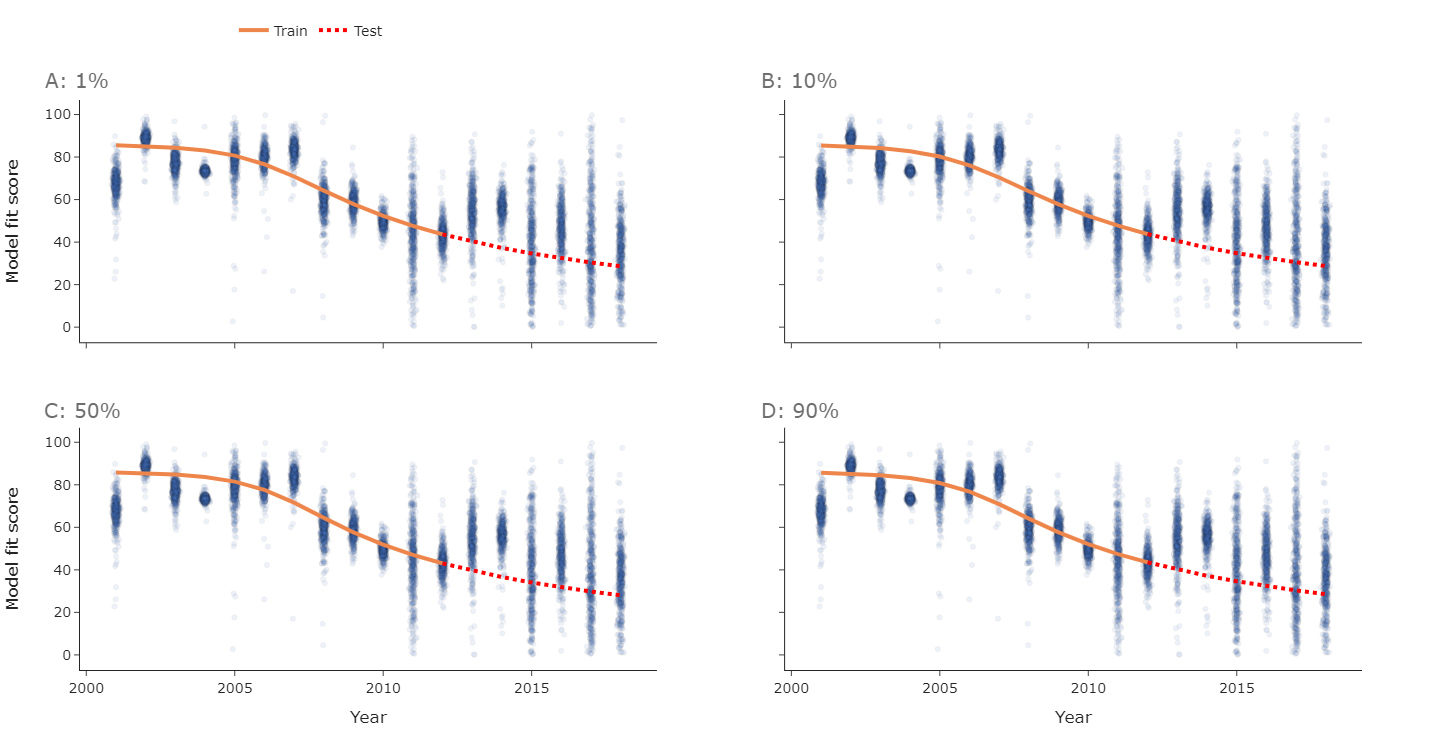

In [41]:
fig2 = app3_fig2(cont_df, solns)
fig2.show()

In [42]:
fig2.write_image('../figures/paper_figs/app3_fig2.png', scale=4)

## Fig 1

Relies on `solns` from fig 2

In [11]:
cont_df_use = (
    cont_df
    .rename(columns = {'control_with_noise_t': 'data_control'})
    .loc[lambda df: df.year>=2013, ['year', 'data_control']]
)

In [12]:
cont_df.loc[lambda df: df.year<=2012]

Unnamed: 0  year     RD    RDU     k    kU    R2   RDnoise    thisRD  \
0              0  2001  0.760  0.033  2.32  0.29  0.99  0.058214  0.818214   
1              1  2001  0.760  0.033  2.32  0.29  0.99  0.013205  0.773205   
2              2  2001  0.760  0.033  2.32  0.29  0.99  0.032298  0.792298   
3              3  2001  0.760  0.033  2.32  0.29  0.99  0.073949  0.833949   
4              4  2001  0.760  0.033  2.32  0.29  0.99  0.061629  0.821629   
...          ...   ...    ...    ...   ...   ...   ...       ...       ...   
5995        5995  2012  0.512  0.032  1.92  0.31  0.98 -0.002125  0.509875   
5996        5996  2012  0.512  0.032  1.92  0.31  0.98 -0.020248  0.491752   
5997        5997  2012  0.512  0.032  1.92  0.31  0.98 -0.005565  0.506435   
5998        5998  2012  0.512  0.032  1.92  0.31  0.98 -0.026426  0.485574   
5999        5999  2012  0.512  0.032  1.92  0.31  0.98  0.006240  0.518240   

        knoise     thisK    control  control_with_noise    yearnoise  \
0     0.001744  2.321744  68.531207           73.794505  2000.960789   
1     0.218304  2.538304  68.531207           71.212175  2001.037995   
2     0.067408  2.387408  68.531207           71.951187  2000.978314   
3     0.171535  2.491535  68.531207           76.491281  2000.871846   
4    -0.296132  2.023868  68.531207           71.305657  2000.944418   
...        ...       ...        ...                 ...          ...   
5995 -0.523986  1.396014  43.693724           38.363908  2012.142520   
5996 -0.295731  1.624269  43.693724           39.484987  2011.953755   
5997 -0.647755  1.272245  43.693724           36.453063  2012.024945   
5998  0.146514  2.066514  43.693724           42.408740  2012.080234   
5999 -0.124926  1.795074  43.693724           43.215212  2011.948279   

       knoiset  RDnoiset   thisRDt    thisKt  control_with_noise_t  
0    -0.045642 -0.033148  0.726852  2.274358             65.208590  
1     0.001437 -0.005557  0.754443  2.321437             68.040734  
2     0.253695 -0.013926  0.746074  2.573695             68.918310  
3    -0.405816 -0.037936  0.722064  1.914184             61.558706  
4     0.541304 -0.009728  0.750272  2.861304             70.736121  
...        ...       ...       ...       ...                   ...  
5995  0.176590  0.013137  0.525137  2.096590             46.061122  
5996 -0.904763  0.023423  0.535423  1.015237             34.143054  
5997  0.022914 -0.039063  0.472937  1.942914             40.517223  
5998 -0.569557  0.008680  0.520680  1.350443             38.575889  
5999  0.135354  0.027328  0.539328  2.055354             47.026884  

[6000 rows x 19 columns]

In [13]:
scores = []

for ii in range(4):
    scores.append(score_for_this_df(cont_df_use, 100*solns[ii][-6:]))

test_scores = (
    pd.DataFrame(dict(
        p=[0.01, 0.1, 0.5, 0.9],
        scores=scores
    ))
    .assign(mean_score = lambda df: df.scores/3000)
)

test_scores

p        scores  mean_score
0  0.01  1.141739e+06  380.579754
1  0.10  1.132829e+06  377.609550
2  0.50  1.185964e+06  395.321458
3  0.90  1.145719e+06  381.906416

In [14]:
fits_use = fits.assign(mean_score=lambda df: df.loss/6000)

In [15]:
fits_use

mu         b     p           loss  mean_score
0   9.694679  0.816062  0.01  650255.262354  108.375877
1   9.442868  0.843157  0.10  650636.453283  108.439409
2  10.355530  0.745018  0.50  650649.892122  108.441649
3   9.837394  0.800507  0.90  650704.425034  108.450738

In [16]:
def app3_fig1(fits, test_scores):
    
    col0 = COLZ[0]
    col1 = COLZ[1]
    
    fig = go.Figure()
    
    data1 = [go.Scatter(
        x=fits.p,
        y=fits.mean_score, 
        line=dict(color=col0),
        name='Training score',
    )]
    
    data2 = [go.Scatter(
        x=test_scores.p,
        y=test_scores.mean_score, 
        line=dict(color=col1),
        name='Test score',
    )]
    
    fig.add_traces(data1)
    fig.add_traces(data2)
    fig.update_layout(standard_layout(True, height=450))
    fig.update_layout(font=dict(size=14))
    fig.update_layout(legend=dict(x=0, y=1.25, orientation='h'))
    
    fig.update_xaxes(title_text='Proportion of maximum mutation scale',
                     range=[-0.01, 1.01],
                     showgrid=False)
    
    fig.update_yaxes(title_text='Model score',
                     range=[-1, 405],
                     showgrid=False)
    
    
    
    return fig

In [17]:
f1 = app3_fig1(fits_use, test_scores)

f1.show()

In [18]:
f1.write_image('../figures/paper_figs/app3_fig1.png', scale=4)

## Fig 3

In [19]:
def get_soln_app3_fig3(p):
    
    conf = Config(
        type='single',
        n_k=500,
        n_l=10,
        mutation_proportion= MUTATION_PROP,
        mutation_scale_fung= p * FUNG_MUTATION_SCALE,
        mutation_scale_host= p * HOST_MUTATION_SCALE,
        sprays=[1, 2, 3],
        host_on=[False]
    )
    
    conf.k_mu = fits.loc[lambda df: df.p==p].iloc[0].mu
    conf.k_b = fits.loc[lambda df: df.p==p].iloc[0].b
    conf.l_mu = NOT_USED
    conf.l_b = NOT_USED
        
    sol = simulations_run(
        conf,
        I0_vec_run=[DEFAULT_I0]*15,
        beta_vec_run=[DEFAULT_BETA]*15,
    )
    
    return sol

In [20]:
solnsA = get_soln_app3_fig3(0.01)
solnsB = get_soln_app3_fig3(0.1)
solnsC = get_soln_app3_fig3(0.5)
solnsD = get_soln_app3_fig3(0.9)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078654159996959
host_on = [False]
k_b = None
k_mu = None
l_b = None
l_mu = None
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.00019836158401698102
mutation_scale_host = 0.00019836158401698102
n_iterations = None
n_k = 500
n_l = 10
n_years = 15
replace_cultivars = None
sprays = [1, 2, 3]
type = single

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078654159996959
host_on = [False]
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_iterations = None
n_k = 500
n_l = 10
n_years = 15
replace_cultivars = None
sprays = [1, 2, 3]
type = single

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078654159996959
host_on = [False]
k_b = None
k_mu = None
l_b = None
l_mu = None
mutation_proportion = 1.234375e-05
mutation_scale_f

In [21]:
def app3_fig3(solnsA, solnsB, solnsC, solnsD):
    
    fig = make_subplots(
        rows=2,
        cols=2,
        shared_xaxes=True,
        shared_yaxes=True,
        # horizontal_spacing=0.15,
        # vertical_spacing=0.15,        
    )
    
    cols = px.colors.sequential.Viridis
    col0 = 'rgb(0.5,0.5,0.5)'
    col1 = cols[6]
    col2 = cols[3]
    col3 = cols[0]
    
    
    # LINES
    
    split_year = floor(
        cont_df.year.min() - 1 +
        TRAIN_TEST_SPLIT_PROPORTION * (1 - cont_df.year.min() + cont_df.year.max())
    )
        
    
    for sol, rr, cc, showledge in zip(
            [solnsA, solnsB, solnsC, solnsD],
            [1,1,2,2],
            [1,2,1,2],
            [True] + [False]*3,
    ):
        
        sev1 = sol['spray_Y1_host_N']['dis_sev']
        sev2 = sol['spray_Y2_host_N']['dis_sev']
        sev3 = sol['spray_Y3_host_N']['dis_sev']
          
        lines = [
            go.Scatter(
                x = np.arange(1, len(sev1)+1),
                y = 100*sev1,
                line=dict(color=col1, dash='dashdot'),
                name='1 spray',
                mode='lines',
                showlegend=showledge
            ),
            go.Scatter(
                x = np.arange(1, len(sev2)+1),
                y = 100*sev2,
                line=dict(color=col2, dash='dash'),
                name='2 sprays',
                mode='lines',
                showlegend=showledge
            ),
            go.Scatter(
                x = np.arange(1, len(sev3)+1),
                y = 100*sev3,
                line=dict(color=col3),
                name='3 sprays',
                mode='lines',
                showlegend=showledge
            ),
        ]
            
        fig.add_traces(lines, rows=rr, cols=cc)
    
    
    col_1 = -0.03
    col_2 = 0.53
    
    row1 = 1.07
    row2 = 0.49

    annotz = [
            
        get_text_annotation(col_1, row1, 'A: 1%', size=20, xanchor='left'),
        get_text_annotation(col_2, row1, 'B: 10%', size=20, xanchor='left'),
        get_text_annotation(col_1, row2, 'C: 50%', size=20, xanchor='left'),
        get_text_annotation(col_2, row2, 'D: 90%', size=20, xanchor='left'),
        
    ]

    fig.update_layout(annotations=annotz)
    
    fig.update_layout(standard_layout(True, height=750))
    fig.update_layout(font=dict(size=14))
    fig.update_layout(legend=dict(
        x=0.5,
        y=1.15,
        xanchor='center',
        orientation='h'
    ))
                                  
    
    fig.update_xaxes(title_text='Year',
                     row=2,
                     col=1,
                     range=[0, 15.5],
                     showgrid=False)
    
    fig.update_xaxes(title_text='Year',
                     row=2,
                     col=2,
                     range=[0, 15.5],
                     showgrid=False)
    
    sev_range = [-1, 15]
    fig.update_yaxes(title_text='Disease severity',
                     row=1,
                     col=1,
                     range=sev_range,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Disease severity',
                     row=2,
                     col=1,
                     range=sev_range,
                     showgrid=False)
    
    
    return fig

In [22]:
fig3 = app3_fig3(solnsA, solnsB, solnsC, solnsD)
fig3.show()

In [23]:
fig3.write_image('../figures/paper_figs/app3_fig3.png', scale=4)

## Testing

### Exploring p = 0.9

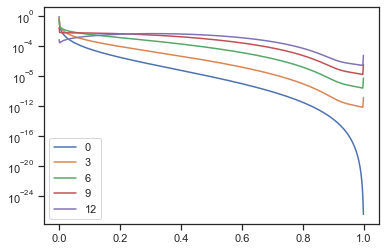

In [24]:
f, ax = plt.subplots()

for i in range(0, 15, 3):
    ax.plot(
        solnsD['spray_Y1_host_N']['k_vec'],
        solnsD['spray_Y1_host_N']['fung_dists'][:, i],
        label=str(i),
    )

ax.set_yscale('log')

ax.legend()

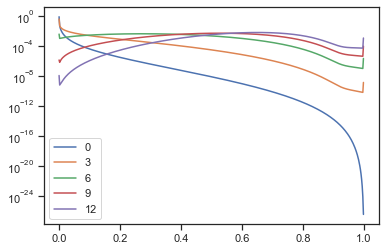

In [25]:
f, ax = plt.subplots()

for i in range(0, 15, 3):
    ax.plot(
        solnsD['spray_Y2_host_N']['k_vec'],
        solnsD['spray_Y2_host_N']['fung_dists'][:, i],
        label=str(i),
    )

ax.set_yscale('log')

ax.legend()

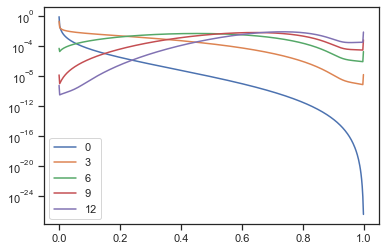

In [26]:
f, ax = plt.subplots()

for i in range(0, 15, 3):
    ax.plot(
        solnsD['spray_Y3_host_N']['k_vec'],
        solnsD['spray_Y3_host_N']['fung_dists'][:, i],
        label=str(i),
    )

ax.set_yscale('log')

ax.legend()

(0.001, 1)

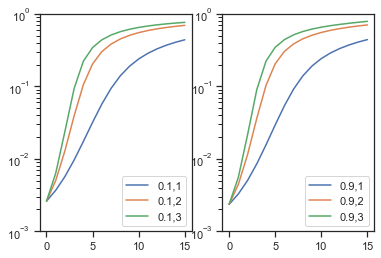

In [27]:
f, ax = plt.subplots(1, 2)


for i in [1, 2, 3]:
    kB = solnsB[f'spray_Y{i}_host_N']['k_vec']
    dB = solnsB[f'spray_Y{i}_host_N']['fung_dists']
    dtB = get_dist_mean(dB, kB)

    ax[0].plot(dtB, label=str(0.1) + ',' + str(i))

    kD = solnsD[f'spray_Y{i}_host_N']['k_vec']
    dD = solnsD[f'spray_Y{i}_host_N']['fung_dists']
    dtD = get_dist_mean(dD, kD)

    ax[1].plot(dtD, label=str(0.9) + ',' + str(i))


ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend()

ax[0].set_ylim([1e-3, 1])
ax[1].set_ylim([1e-3, 1])

(1e-10, 0.01)

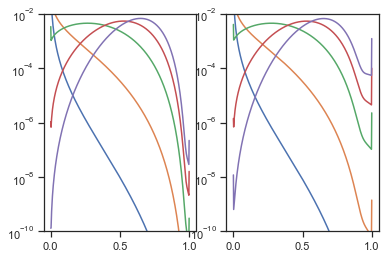

In [28]:
f, ax = plt.subplots(1, 2)

for i in range(0, 15, 3):
    
    ax[0].plot(
        solnsB['spray_Y2_host_N']['k_vec'],
        solnsB['spray_Y2_host_N']['fung_dists'][:, i],
        label=str(i),
    )
    
    ax[1].plot(
        solnsD['spray_Y2_host_N']['k_vec'],
        solnsD['spray_Y2_host_N']['fung_dists'][:, i],
        label=str(i),
    )

ax[0].set_yscale('log')
ax[1].set_yscale('log')
# ax[0].set_ylim([1e-10, 1])
# ax[1].set_ylim([1e-10, 1])

# ax[0].legend()
# ax[1].legend()

ax[0].set_ylim([1e-10, 1e-2])
ax[1].set_ylim([1e-10, 1e-2])

Ok so here we have 2 sprays, 0.1 vs 0.9.

0.9 has shape parameter 6.7 vs 0.1 shape param 0.73. This means has smaller variance, think mutation gets away from mu=0 initially and then small variance means it then slows down.

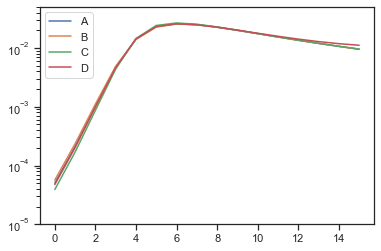

In [29]:
f, ax = plt.subplots()

ax.plot(get_dist_var(
    solnsA['spray_Y2_host_N']['fung_dists'],
    solnsA['spray_Y2_host_N']['k_vec']),
    label='A'
)

ax.plot(get_dist_var(
    solnsB['spray_Y2_host_N']['fung_dists'],
    solnsB['spray_Y2_host_N']['k_vec']),
    label='B'
)

ax.plot(get_dist_var(
    solnsC['spray_Y2_host_N']['fung_dists'],
    solnsC['spray_Y2_host_N']['k_vec']
    ),
    label='C'
)

ax.plot(
    get_dist_var(
        solnsD['spray_Y2_host_N']['fung_dists'],
        solnsD['spray_Y2_host_N']['k_vec']
    ), 
    label='D'
)

ax.set_ylim([1e-5, 5e-2])

ax.set_yscale('log')

ax.legend()